In [1]:
%%capture
!pip install rdkit
!pip install torch_geometric

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import seaborn as sns
import networkx as nx
from math import sqrt

from rdkit import Chem
from rdkit.Chem import AllChem, Draw, PandasTools, Descriptors
# from rdkit.Chem.rdmolops import GetAdjacencyMatrix
# from rdkit.Chem.Draw import IPythonConsole
# from tqdm import tqdm

import torch.nn.functional as F
from torch.utils.data import random_split

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_networkx
from torch_geometric.nn import AttentiveFP

In [3]:
import os
import random
from collections import Counter

import torch

from torch_geometric.data import InMemoryDataset, download_url, extract_gz
from torch_geometric.utils import from_smiles
from sklearn.metrics import r2_score, mean_squared_error

In [4]:
# print(plt.style.available)
plt.style.use('ggplot')

In [5]:
def seed_set(seed=50):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [6]:
seed_set()

## **Loading the Dataset**

In [7]:
df_final = pd.read_csv('Lipophilicity_final.csv')

In [8]:
df_final.head()

,CMPD_CHEMBLID,exp,smiles
0,CHEMBL596271,3.54,Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14
1,CHEMBL1951080,-1.18,COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)...
2,CHEMBL1771,3.69,COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl
3,CHEMBL234951,3.37,OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(C...
4,CHEMBL565079,3.10,Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)N...


In [9]:
df_final.describe()

,exp
count,4192.000000
mean,2.186591
std,1.201077
min,-1.500000
25%,1.410000
50%,2.360000
75%,3.100000
max,4.500000


In [10]:
# df_final['exp'].describe()

In [11]:
lipo_cls = [int(boolean) for boolean in list(map(lambda s: s>2.36, df_final['exp']))]

In [12]:
from collections import Counter
Counter(lipo_cls)

Counter({1: 2088, 0: 2104})

In [13]:
df_final['labels'] = lipo_cls

In [14]:
df_final.head()

,CMPD_CHEMBLID,exp,smiles,labels
0,CHEMBL596271,3.54,Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14,1
1,CHEMBL1951080,-1.18,COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)...,0
2,CHEMBL1771,3.69,COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl,1
3,CHEMBL234951,3.37,OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(C...,1
4,CHEMBL565079,3.10,Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)N...,1


In [15]:
graph_list = []
for i, smile in enumerate(df_final['smiles']):
  g = from_smiles(smile)
  g.x = g.x.float()
  y = torch.tensor(df_final['labels'][i], dtype=torch.float).view(1, -1)
  g.y = y
  graph_list.append(g)

In [16]:
len(graph_list)

4192

In [17]:
train_ratio = 0.80  # 80% for training, 20% for testing
dataset_size = len(graph_list)
train_size = int(train_ratio * dataset_size)
test_size = dataset_size - train_size

# Split the dataset into train and test subsets
generator1 = torch.Generator().manual_seed(42)
train_dataset, test_dataset = random_split(graph_list, [train_size, test_size], generator=generator1)

In [18]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = AttentiveFP(in_channels=9, hidden_channels=64, out_channels=1,
                    edge_dim=3, num_layers=4, num_timesteps=2,
                    dropout=0.2).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=10**-2.5,
                             weight_decay=10**-5)

In [20]:
def train():
    total_loss = total_samples = 0
    correct_predictions = 0
    model.train()

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)

        # Apply sigmoid activation for binary classification
        out = torch.sigmoid(out)

        loss = F.binary_cross_entropy(out, data.y)
        loss.backward()
        optimizer.step()

        total_loss += float(loss) * data.num_graphs
        total_samples += data.num_graphs

        # Calculate number of correct predictions
        preds = (out > 0.5).float()
        correct_predictions += (preds == data.y).sum().item()

    accuracy = correct_predictions / (total_samples * data.y.size(1))  # Assuming data.y is of shape [batch_size, num_classes]
    return total_loss / total_samples, accuracy

In [21]:
@torch.no_grad()
def test(loader):
    total_loss = total_samples = 0
    correct_predictions = 0
    model.eval()

    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)

        # Apply sigmoid activation for binary classification
        out = torch.sigmoid(out)

        loss = F.binary_cross_entropy(out, data.y, reduction='sum')
        total_loss += float(loss)
        total_samples += data.num_graphs

        # Calculate number of correct predictions
        preds = (out > 0.5).float()
        correct_predictions += (preds == data.y).sum().item()

    accuracy = correct_predictions / (total_samples * data.y.size(1))  # Assuming data.y is of shape [batch_size, num_classes]
    average_loss = total_loss / total_samples
    return average_loss, accuracy

Epoch: 000, Train Loss: 0.7075, Train Accuracy: 0.5365, Test Loss: 0.6856, Test Accuracy: 0.5530
Epoch: 001, Train Loss: 0.6852, Train Accuracy: 0.5520, Test Loss: 0.6984, Test Accuracy: 0.5089
Epoch: 002, Train Loss: 0.6804, Train Accuracy: 0.5664, Test Loss: 0.6771, Test Accuracy: 0.5530
Epoch: 003, Train Loss: 0.6688, Train Accuracy: 0.5854, Test Loss: 0.6615, Test Accuracy: 0.6091
Epoch: 004, Train Loss: 0.6642, Train Accuracy: 0.5917, Test Loss: 0.6566, Test Accuracy: 0.6043
Epoch: 005, Train Loss: 0.6591, Train Accuracy: 0.6016, Test Loss: 0.6744, Test Accuracy: 0.5387
Epoch: 006, Train Loss: 0.6523, Train Accuracy: 0.6215, Test Loss: 0.6508, Test Accuracy: 0.6198
Epoch: 007, Train Loss: 0.6530, Train Accuracy: 0.6171, Test Loss: 0.6461, Test Accuracy: 0.6341
Epoch: 008, Train Loss: 0.6437, Train Accuracy: 0.6305, Test Loss: 0.6642, Test Accuracy: 0.6055
Epoch: 009, Train Loss: 0.6437, Train Accuracy: 0.6314, Test Loss: 0.6705, Test Accuracy: 0.5864
Epoch: 010, Train Loss: 0.6355

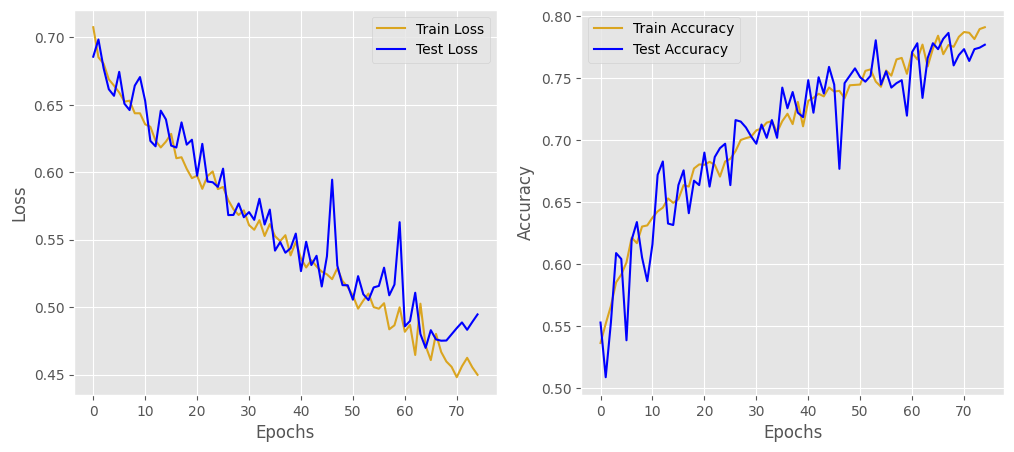

In [22]:
score_train_loss = []
score_train_acc = []
score_test_loss = []
score_test_acc = []

epochs = 75
model.reset_parameters()

for epoch in range(epochs):
    train_loss, train_acc = train()
    test_loss, test_acc = test(test_loader)

    score_train_loss.append(train_loss)
    score_train_acc.append(train_acc)
    score_test_loss.append(test_loss)
    score_test_acc.append(test_acc)

    print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, '
          f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), score_train_loss, c='goldenrod')
plt.plot(range(epochs), score_test_loss, c='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train Loss', 'Test Loss'])

plt.subplot(1, 2, 2)
plt.plot(range(epochs), score_train_acc, c='goldenrod')
plt.plot(range(epochs), score_test_acc, c='blue')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train Accuracy', 'Test Accuracy'])

plt.show()

In [23]:
torch.save(model, '/content/model_lipo_class.pth')